In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction


In [2]:
# pip install torch matplotlib seaborn

In [3]:
import math

import numpy as np
import pandas as pd


import torch

from src.tennisracketswingweightprediction.modules.models import (
    Discriminator,
    Generator,
    ResidualGenerator,
    ResidualDiscriminator,
)

from src.tennisracketswingweightprediction.modules.gan_trainer import GANTrainer
from src.tennisracketswingweightprediction.modules.torch_preprocessing import (
    TabularDataProcessor,
)

In [4]:
data = pd.read_csv("data/racquet_data.csv")

In [5]:
data.head()

,pcode,mfg,racquet,headsize,length,weight,balance,swingweight,flex,acor,...,hittingweight,vibration,filter,distance,spin,angle,shotspeed,swingspeed,plow,time
0,VS5,Volkl,V-Sense 5,100,27.0,276,33.5,281,70,0.255,...,114,164,21/2-effort,68.5,1596,3.6,64.5,51.4,37,0.89
1,U100UL,Wilson,Ultra 100UL,100,27.0,270,34.0,283,68,0.260,...,116,164,21/2-effort,68.5,1595,3.6,64.8,51.3,38,0.88
2,BULS1H,Wilson,Burn 100 ULS (2017),100,27.0,281,34.1,288,67,0.273,...,119,158,21/2-effort,68.2,1579,3.4,65.2,51.0,39,0.87
3,YEZLLG,Yonex,Ezone Lite,100,27.0,282,33.3,292,64,0.272,...,119,156,21/2-effort,68.1,1579,3.4,65.2,51.0,39,0.87
4,TPS270,Tecnifibre,T-Flash PS 270,100,27.0,285,34.1,293,69,0.271,...,119,160,21/2-effort,67.8,1570,3.5,64.9,50.7,39,0.87


In [6]:
data = data[data["length"] == 27.0]  # focus on 27 inch rackets

In [7]:
# X = data[['headsize', 'length', 'weight', 'balance',
#        'swingweight', 'flex', 'acor', 'sweet',
#        'twistweight', 'hittingweight', 'vibration', 'distance',
#        'spin', 'angle', 'shotspeed', 'swingspeed', 'plow', 'time']]
X = data[["headsize", "weight", "balance", "flex", "swingweight"]]

In [8]:
data

,pcode,mfg,racquet,headsize,length,weight,balance,swingweight,flex,acor,...,hittingweight,vibration,filter,distance,spin,angle,shotspeed,swingspeed,plow,time
0,VS5,Volkl,V-Sense 5,100,27.0,276,33.5,281,70,0.255,...,114,164,21/2-effort,68.5,1596,3.6,64.5,51.4,37,0.89
1,U100UL,Wilson,Ultra 100UL,100,27.0,270,34.0,283,68,0.260,...,116,164,21/2-effort,68.5,1595,3.6,64.8,51.3,38,0.88
2,BULS1H,Wilson,Burn 100 ULS (2017),100,27.0,281,34.1,288,67,0.273,...,119,158,21/2-effort,68.2,1579,3.4,65.2,51.0,39,0.87
3,YEZLLG,Yonex,Ezone Lite,100,27.0,282,33.3,292,64,0.272,...,119,156,21/2-effort,68.1,1579,3.4,65.2,51.0,39,0.87
4,TPS270,Tecnifibre,T-Flash PS 270,100,27.0,285,34.1,293,69,0.271,...,119,160,21/2-effort,67.8,1570,3.5,64.9,50.7,39,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,PT95,Prince,Tour 95,95,27.0,345,32.4,337,60,0.323,...,136,131,21/2-effort,65.8,1491,2.9,66.2,48.9,43,0.82
258,HG3RMP,Head,Graphene 360 Radical MP,98,27.0,312,32.4,324,68,0.305,...,130,152,21/2-effort,66.8,1526,3.1,66.0,49.7,42,0.84
260,HGTRMP,Head,Graphene Touch Radical MP,98,27.0,310,33.0,327,65,0.313,...,132,151,21/2-effort,66.6,1519,3.0,66.3,49.6,42,0.84
261,BS0398,Prince,Textreme Beast O3 98,98,27.0,318,32.5,326,69,0.316,...,133,155,21/2-effort,66.7,1519,2.9,66.5,49.6,42,0.83


In [9]:
cols = ["headsize", "weight", "balance", "flex", "swingweight"]

processor = TabularDataProcessor(data, cols, device="cpu")
train_loader, input_dim = processor.process(batch_size=32)
scaler = processor.get_scaler()

In [24]:
trainers = {
    "base": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=0.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=0.0,  # Enable Correlation Matching
    ), 
    "div_weight": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=1.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=0.0,  # Enable Correlation Matching
    ), 
    "corr_weight": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=0.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=1.0,  # Enable Correlation Matching
    ), 
    "div_corr_weight": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=0.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=1.0,  # Enable Correlation Matching
    ), 
}

metrics_dict = {}
for name, trainer in trainers.items():

    trainer.train_loop(train_loader, epochs=100, g_update_freq=1)

    real_data_sample = data[cols].values

    samples = trainer.get_generated_samples(len(real_data_sample))

    # 1. Plot comparison
    #trainer.plot_distribution_comparison(real_data_sample, samples, feature_names=cols)

    # 2. Print metrics
    metrics = trainer.evaluate_quality(real_data_sample, samples)
    metrics_dict[name] = metrics

Starting training on cpu for 100 epochs...
Epoch [1/100] | D Loss: 0.7080 | G Loss: 0.8283
Epoch [2/100] | D Loss: 0.6142 | G Loss: 0.9786
Epoch [3/100] | D Loss: 0.7660 | G Loss: 0.7698
Epoch [4/100] | D Loss: 0.6034 | G Loss: 0.9943
Epoch [5/100] | D Loss: 0.7968 | G Loss: 0.7912
Epoch [6/100] | D Loss: 0.5839 | G Loss: 1.2125
Epoch [7/100] | D Loss: 0.6111 | G Loss: 1.3008
Epoch [8/100] | D Loss: 0.5671 | G Loss: 1.3110
Epoch [9/100] | D Loss: 0.4303 | G Loss: 1.5823
Epoch [10/100] | D Loss: 0.5835 | G Loss: 1.2125
Epoch [11/100] | D Loss: 0.4877 | G Loss: 1.4491
Epoch [12/100] | D Loss: 0.4581 | G Loss: 1.9696
Epoch [13/100] | D Loss: 0.5775 | G Loss: 1.4064
Epoch [14/100] | D Loss: 0.4416 | G Loss: 1.5564
Epoch [15/100] | D Loss: 0.3907 | G Loss: 1.6868
Epoch [16/100] | D Loss: 0.8430 | G Loss: 1.0197
Epoch [17/100] | D Loss: 0.8779 | G Loss: 0.7934
Epoch [18/100] | D Loss: 0.7648 | G Loss: 1.0587
Epoch [19/100] | D Loss: 0.7061 | G Loss: 1.1202
Epoch [20/100] | D Loss: 0.7655 | G

In [27]:
metrics_dict

{'base': {'avg_wasserstein_dist': np.float64(5.274458291190011),
  'correlation_diff': np.float64(2.336773305100144),
  'mean_abs_diff': np.float64(3.2546223398844374),
  'std_abs_diff': np.float64(5.115493931755013)},
 'div_weight': {'avg_wasserstein_dist': np.float64(0.886113925388881),
  'correlation_diff': np.float64(0.5379008385493783),
  'mean_abs_diff': np.float64(0.471711802164711),
  'std_abs_diff': np.float64(0.13199930924756392)},
 'corr_weight': {'avg_wasserstein_dist': np.float64(1.3775461015247163),
  'correlation_diff': np.float64(0.3285717173350435),
  'mean_abs_diff': np.float64(0.7164203520275322),
  'std_abs_diff': np.float64(0.5127834391981019)},
 'div_corr_weight': {'avg_wasserstein_dist': np.float64(2.097496162777855),
  'correlation_diff': np.float64(0.4087444259493862),
  'mean_abs_diff': np.float64(1.169776987711586),
  'std_abs_diff': np.float64(0.7585951400190247)}}

In [29]:
def dict_to_markdown_table(results_dict, 
                          approach_names=None,
                          metric_names=None,
                          transpose=False,
                          lower_is_better=True,
                          title="Results",
                          caption="",
                          output_file=None):
    """
    Convert nested dict of results to markdown table.
    
    Args:
        results_dict: Dict with structure {approach: {metric: value}}
        approach_names: Dict to rename approaches (optional)
        metric_names: Dict to rename metrics (optional)
        transpose: If True, metrics as rows, approaches as columns
        lower_is_better: If True, minimum is highlighted; else maximum
        title: Table title
        caption: Table caption
        output_file: Path to save markdown file (optional)
    
    Returns:
        Markdown string
    """
    if transpose:
        df = pd.DataFrame(results_dict)
        if metric_names:
            df.index = df.index.map(metric_names)
        if approach_names:
            df.columns = df.columns.map(approach_names)
        
        # Format row-wise
        df_formatted = df.copy()
        for idx in df_formatted.index:
            values = df_formatted.loc[idx].values.astype(float)
            best_val = values.min() if lower_is_better else values.max()
            
            formatted = []
            for val in values:
                if val == best_val:
                    formatted.append(f"**{val:.4f}**")
                else:
                    formatted.append(f"{val:.4f}")
            df_formatted.loc[idx] = formatted
    else:
        df = pd.DataFrame(results_dict).T
        df.index.name = 'Approach'
        df = df.reset_index()
        
        if approach_names:
            df['Approach'] = df['Approach'].map(approach_names)
        if metric_names:
            cols = ['Approach'] + [metric_names.get(c, c) for c in df.columns if c != 'Approach']
            df.columns = cols
        
        df_formatted = df.set_index('Approach').copy()
        for col in df_formatted.columns:
            values = df_formatted[col].values.astype(float)
            best_val = values.min() if lower_is_better else values.max()
            
            formatted = []
            for val in values:
                if val == best_val:
                    formatted.append(f"**{val:.4f}**")
                else:
                    formatted.append(f"{val:.4f}")
            df_formatted[col] = formatted
    
    # Build output
    output = f"# {title}\n\n"
    if caption:
        output += f"*{caption}*\n\n"
    
    better_str = "Lower" if lower_is_better else "Higher"
    output += f"*{better_str} values indicate better performance. Bold indicates best result per metric.*\n\n"
    output += df_formatted.to_markdown() + "\n"
    
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
    
    return output

# Usage
approach_names = {
    'base': 'Baseline',
    'div_weight': 'Diversity Loss',
    'corr_weight': 'Correlation Loss',
    'div_corr_weight': 'Diversity + Correlation'
}

metric_names = {
    'avg_wasserstein_dist': 'Wasserstein Distance',
    'correlation_diff': 'Correlation Difference',
    'mean_abs_diff': 'Mean Absolute Difference',
    'std_abs_diff': 'Std Absolute Difference'
}


markdown = dict_to_markdown_table(
    metrics_dict,
    approach_names=approach_names,
    metric_names=metric_names,
    transpose=True,  # Change to False for approaches as rows
    lower_is_better=True,
    title="GAN Training Results",
    caption="Comparison of different loss configurations on tennis racket dataset (n=210).",
    output_file="gan_results.md"
)


/var/folders/_7/c4_dw8hd4331ws63qv0t0cym0000gn/T/ipykernel_64475/2769690103.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.2745' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_formatted.loc[idx] = formatted
/var/folders/_7/c4_dw8hd4331ws63qv0t0cym0000gn/T/ipykernel_64475/2769690103.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**0.8861**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_formatted.loc[idx] = formatted
/var/folders/_7/c4_dw8hd4331ws63qv0t0cym0000gn/T/ipykernel_64475/2769690103.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3775' has dtype incompatible with float64, please explicitly cast to a compatible dtype firs

NameError: name 'dict_to_markdown_table' is not defined

,avg_wasserstein_dist,correlation_diff,mean_abs_diff,std_abs_diff
base,5.274458,2.336773,3.254622,5.115494
div_weight,0.886114,0.537901,0.471712,0.131999
corr_weight,1.377546,0.328572,0.716420,0.512783
div_corr_weight,2.097496,0.408744,1.169777,0.758595


In [26]:
pip install tabulate



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


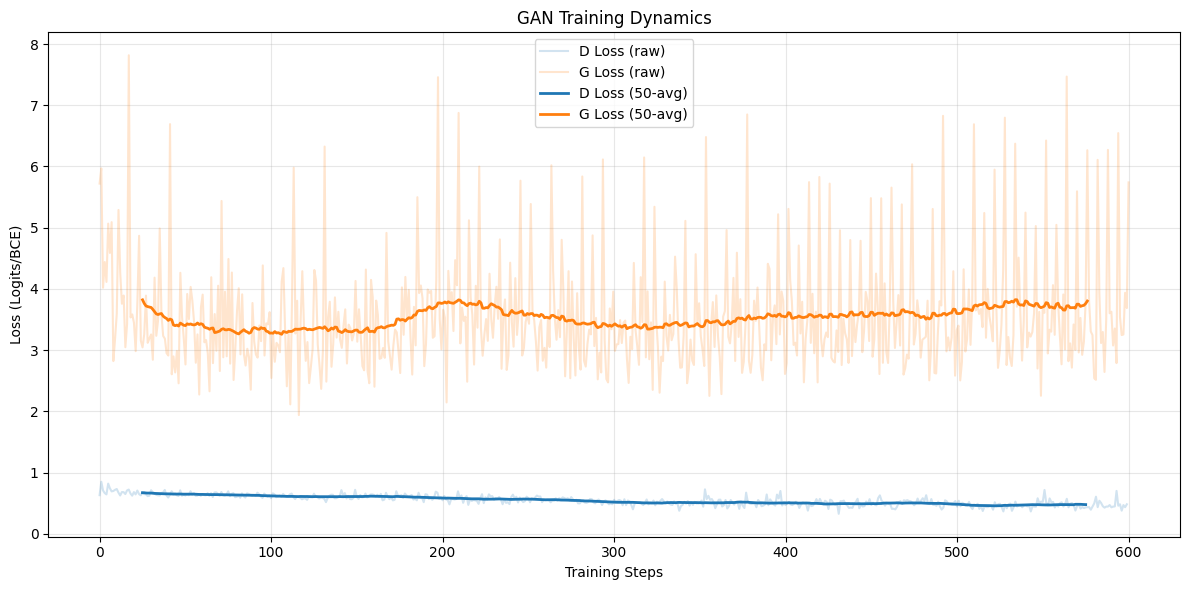

In [11]:
trainer.plot_losses()

In [12]:
samples_df = pd.DataFrame(
    samples, columns=["headsize", "weight", "balance", "flex", "swingweight"]
)

samples_df.describe()

,headsize,weight,balance,flex,swingweight
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,99.135017,316.031525,32.940166,65.503532,317.413788
std,2.119484,17.445662,0.815419,4.084072,10.818211
min,93.380226,279.289856,31.440012,54.785130,288.334015
25%,98.631229,303.540848,32.277090,62.844929,309.163521
50%,99.947273,320.322647,32.889750,65.255894,320.175613
75%,100.212873,329.847404,33.421369,68.665031,324.344482
max,104.362808,343.659912,34.905140,73.405533,339.167206


In [13]:
data[["headsize", "weight", "balance", "flex", "swingweight"]].describe()

,headsize,weight,balance,flex,swingweight
count,210.000000,210.000000,210.000000,210.000000,210.000000
mean,99.128571,314.047619,32.951905,65.666667,316.076190
std,2.230206,17.450343,0.809230,3.918223,11.107733
min,93.000000,270.000000,31.200000,54.000000,281.000000
25%,98.000000,301.000000,32.400000,63.000000,309.000000
50%,100.000000,318.000000,33.000000,66.000000,317.500000
75%,100.000000,326.000000,33.500000,69.000000,324.000000
max,107.000000,349.000000,35.600000,75.000000,343.000000


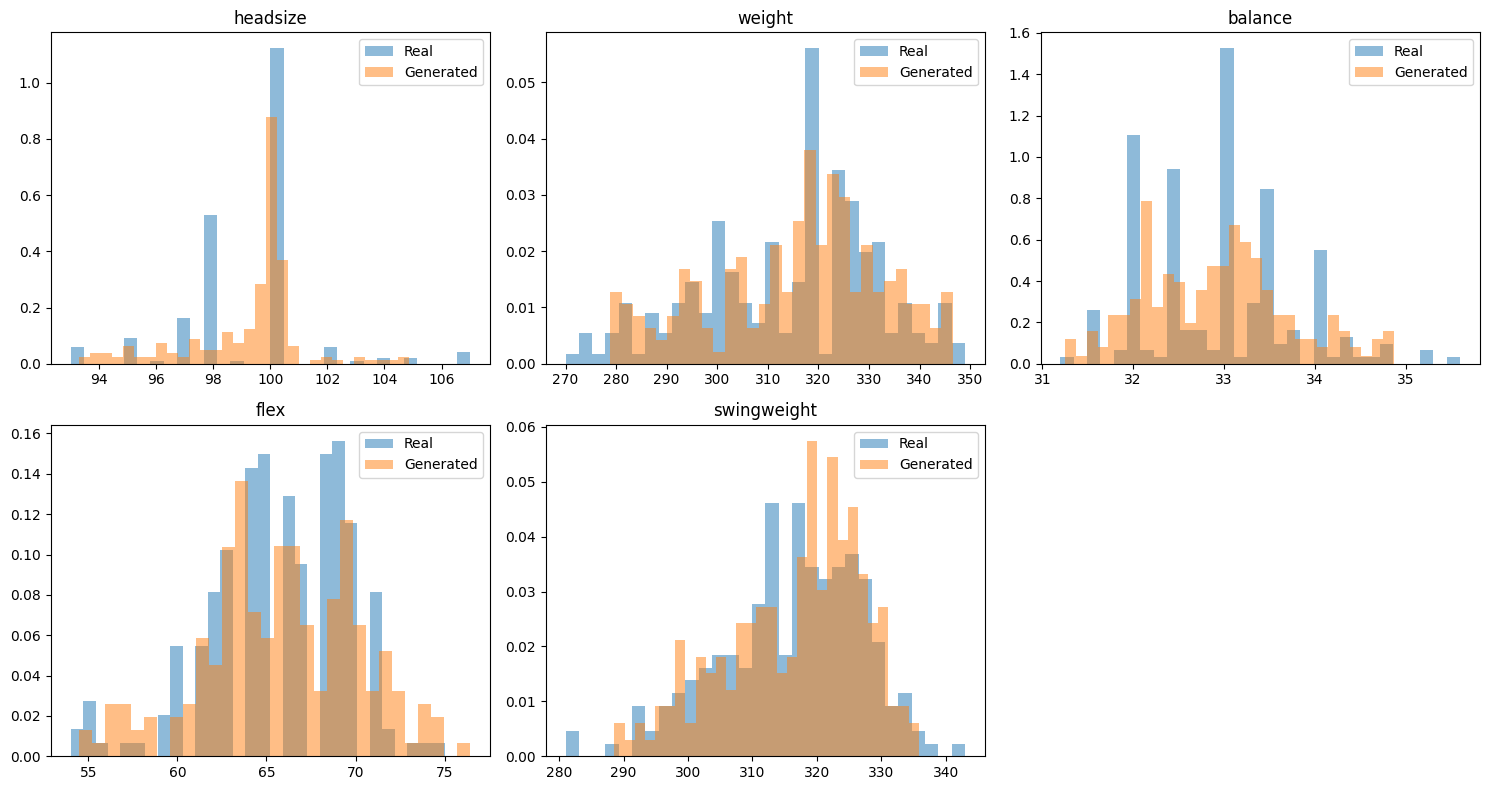


Quality Metrics:
avg_wasserstein_dist: 0.8058
correlation_diff: 0.2402
mean_abs_diff: 0.5065
std_abs_diff: 0.3379


In [15]:
real_data_sample = data[cols].values

samples = trainer.get_generated_samples(len(real_data_sample))

# 1. Plot comparison
trainer.plot_distribution_comparison(real_data_sample, samples, feature_names=cols)

# 2. Print metrics
metrics = trainer.evaluate_quality(real_data_sample, samples)
print("\nQuality Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

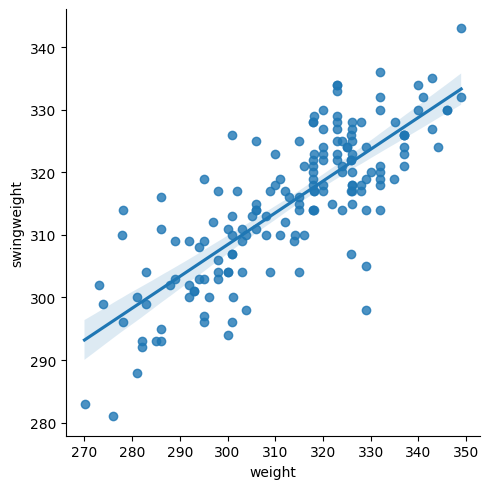

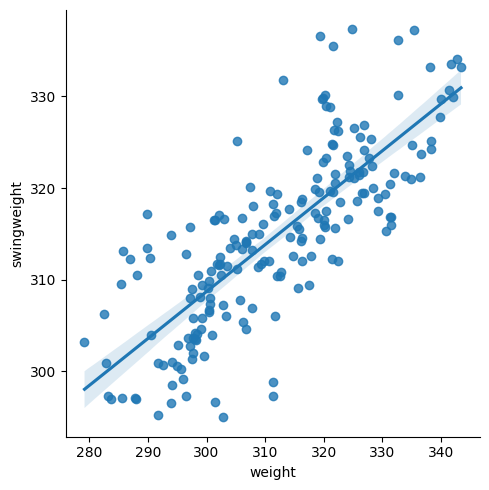

In [ ]:
%matplotlib inline
import seaborn as sns

sns.lmplot(x="weight", y="swingweight", data=X_train, x_jitter=0.05)
sns.lmplot(x="weight", y="swingweight", data=synthetic_data[:200], x_jitter=0.05);

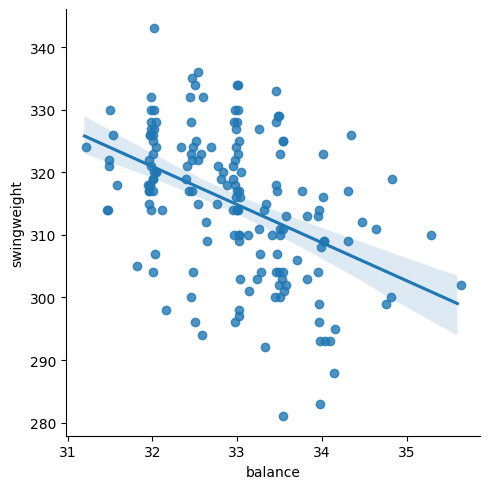

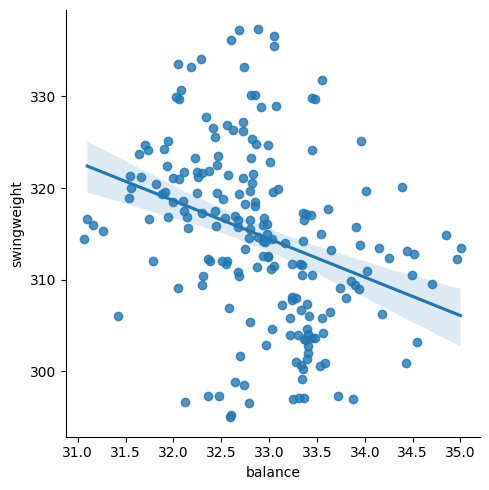

In [ ]:
sns.lmplot(x="balance", y="swingweight", data=X_train, x_jitter=0.05)
sns.lmplot(x="balance", y="swingweight", data=synthetic_data[:200], x_jitter=0.05);

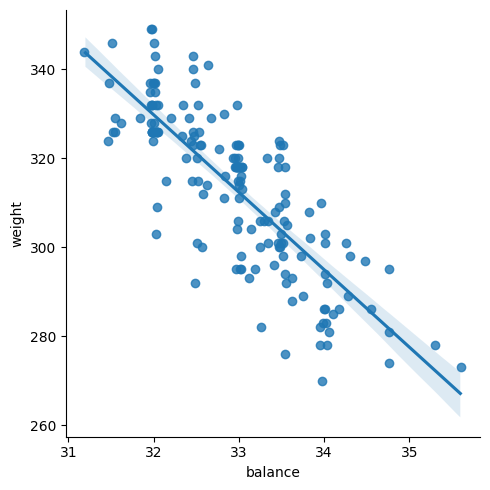

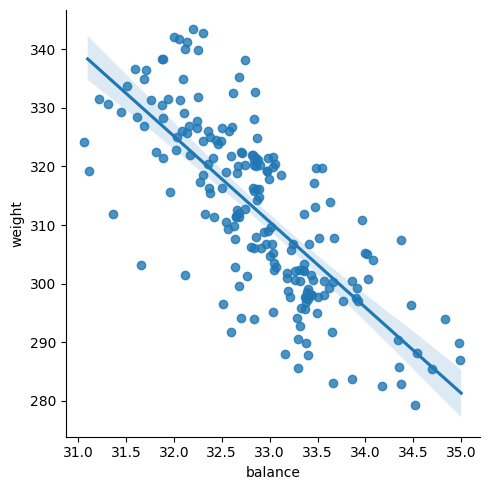

In [ ]:
sns.lmplot(x="balance", y="weight", data=X_train, x_jitter=0.05)
sns.lmplot(x="balance", y="weight", data=synthetic_data[:200], x_jitter=0.05);

In [ ]:
from evaluation import *

synthetic_data

,weight,balance,swingweight
0,321.9,32.2,315.6
1,300.6,33.3,308.0
2,318.8,32.7,321.1
3,319.8,33.5,329.8
4,307.8,33.7,313.2
...,...,...,...
995,290.1,35.0,313.7
996,335.2,32.0,322.2
997,330.7,31.7,314.9
998,312.1,33.4,312.9


In [ ]:
# train base model with normal train data
features = ["weight", "balance"]
label = ["swingweight"]

train_score 0.7484418891742222
test_score 0.43165747756761386
mean_absolute_error 5.061076978586631
RMSE 6.324186348706611
median_absolute_error 4.2381084588813565


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


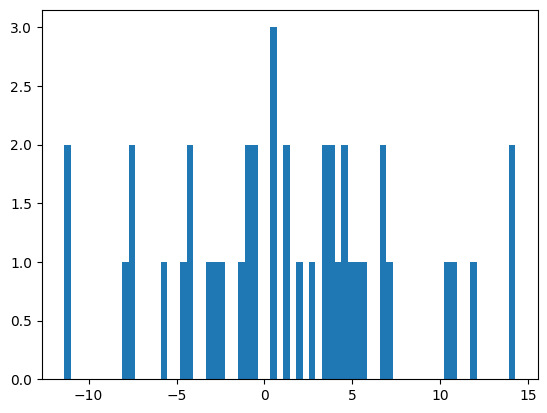

In [ ]:
from sklearn.linear_model import LinearRegression, BayesianRidge

evaluate_model(
    LinearRegression(),
    X_train[features],
    X_train[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_score 0.7483621689281403
test_score 0.4357211177981515
mean_absolute_error 5.048147525338852
RMSE 6.301536873019395
median_absolute_error 4.230568358161406


,max_iter,300
,tol,0.001
,alpha_1,1e-06
,alpha_2,1e-06
,lambda_1,1e-06
,lambda_2,1e-06
,alpha_init,None
,lambda_init,None
,compute_score,False
,fit_intercept,True
,copy_X,True


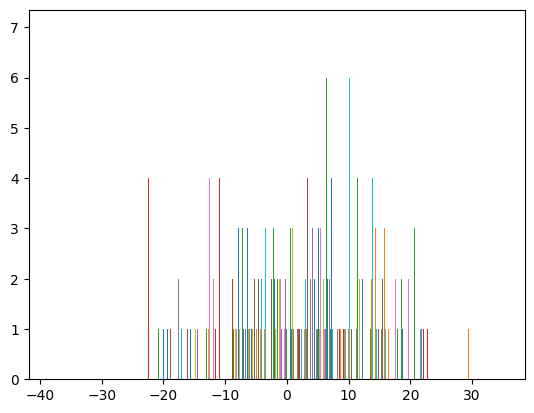

In [ ]:
evaluate_model(
    BayesianRidge(),
    X_train[features],
    X_train[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_score 0.7832777696527717
test_score 0.46547889817320487
mean_absolute_error 4.8821596154197895
RMSE 6.133127746127886
median_absolute_error 3.6369551921277434


,max_iter,300
,tol,0.001
,alpha_1,1e-06
,alpha_2,1e-06
,lambda_1,1e-06
,lambda_2,1e-06
,alpha_init,None
,lambda_init,None
,compute_score,False
,fit_intercept,True
,copy_X,True


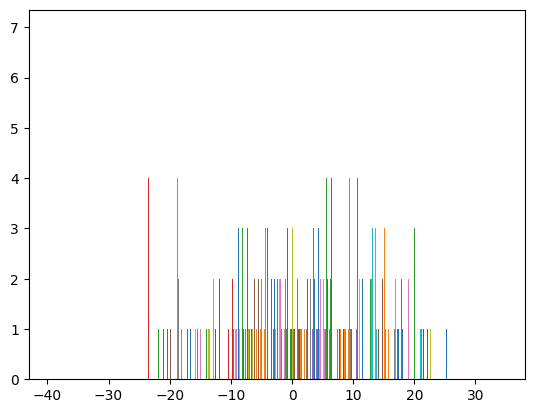

In [ ]:
evaluate_model(
    BayesianRidge(),
    synthetic_data[features],
    synthetic_data[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_score 0.7826847050281172
test_score 0.4744989013274994
mean_absolute_error 4.843050993157301
RMSE 6.081159540082208
median_absolute_error 3.5446838771718774


array([0.7785281 , 6.97334008])

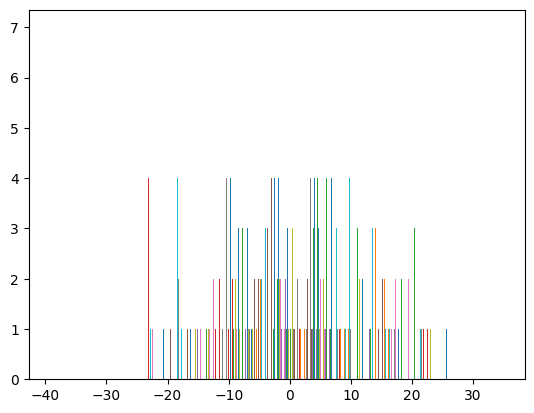

In [ ]:
from sklearn.linear_model import ElasticNetCV

model = evaluate_model(
    ElasticNetCV(
        l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        cv=5,
        random_state=0,
    ),
    synthetic_data[features],
    synthetic_data[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)
model.coef_

train_score 0.7823848110363559
test_score 0.4762024308123275
mean_absolute_error 4.837150641263828
RMSE 6.07129481872658
median_absolute_error 3.6029757682117634


,kernel,DotProduct(si...ise_level=0.8)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,DotProduct(sigma_0=1)
,kernel__k2,WhiteKernel(noise_level=0.8)
,kernel__k1__sigma_0,1.0


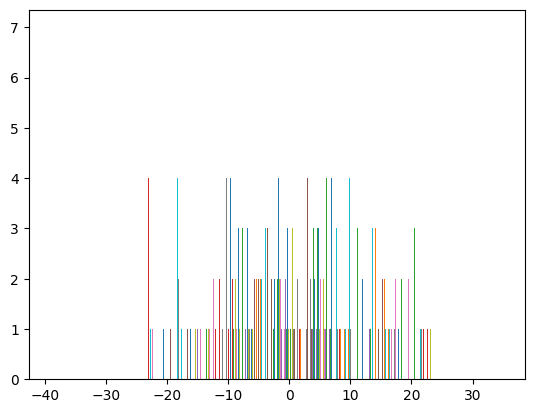

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel(noise_level=0.8)
evaluate_model(
    GaussianProcessRegressor(kernel=kernel, random_state=42),
    synthetic_data[features],
    synthetic_data[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

train_score 0.9466112393782682
test_score 0.30996133772348944
mean_absolute_error 5.830643424036274
RMSE 6.968451720190043
median_absolute_error 5.359999999999985


,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


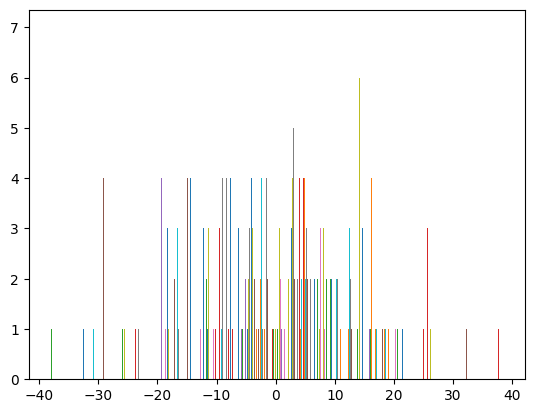

In [ ]:
from sklearn import tree

evaluate_model(
    tree.DecisionTreeRegressor(max_depth=10),
    synthetic_data[features],
    synthetic_data[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_score 0.7505449067750105
test_score 0.39890248277928253
mean_absolute_error 5.178543857207821
RMSE 6.503872969557796
median_absolute_error 3.659493670885979


,estimator,None
,n_estimators,30
,learning_rate,1.0
,loss,'square'
,random_state,None


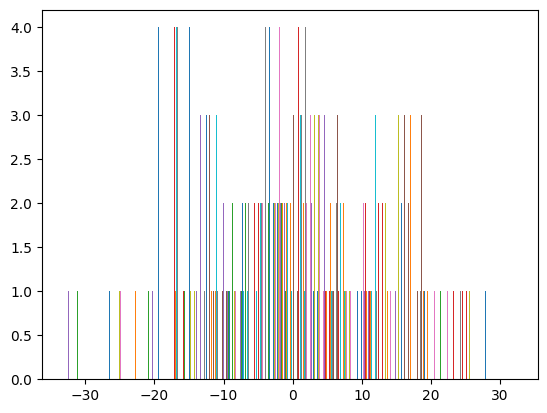

In [ ]:
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

evaluate_model(
    AdaBoostRegressor(n_estimators=30, loss="square"),
    synthetic_data[features],
    synthetic_data[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

In [ ]:
from xgboost import XGBRegressor
from scipy.stats import uniform

regr = XGBRegressor(random_state=42, n_estimators=50, max_depth=1)
evaluate_model(
    regr,
    synthetic_data[features],
    synthetic_data[label].to_numpy(),
    X_test[features],
    X_test[label].to_numpy(),
)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
5 % 4

In [ ]:
from autosklearn.regression import AutoSklearnRegressor

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
automl = AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_multioutput_regression_example_tmp1",
    memory_limit=None,
)

NameError: name 'AutoSklearnRegressor' is not defined

In [ ]:
automl.fit(X_train[features], X_train[label].to_numpy(), dataset_name="synthetic")

NameError: name 'automl' is not defined

In [ ]:
print(automl.leaderboard())

NameError: name 'automl' is not defined

In [ ]:
automl.show_models()

NameError: name 'automl' is not defined

In [ ]:
predictions = automl.predict(X_test[features])
predictions

NameError: name 'automl' is not defined

In [ ]:
from sklearn.metrics import r2_score

r2_score(predictions, X_test[label])

0.42393406006151346